In [1]:
from tensorflow.python.client import device_lib
devices=device_lib.list_local_devices()
print(devices)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16673070682243103302
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14234419200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5571757866717757888
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"]="Malgun Gothic"
plt.rcParams["axes.unicode_minus"]=False

from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 이전 결과를 반영해서 더 나은 조합 시도 (똑똑한 탐색)
from keras_tuner.tuners import BayesianOptimization
#from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel

In [4]:
new_base="../../data/processed/02_kaggle_dataset/train"
IMG_SIZE=86
BATCH_SIZE=16

SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"]=str(SEED)

# 메모리 점유 안되게 GPU에 여유 있게 할당
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [5]:
datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    validation_split=0.2  # train/val
)

# 80%
train_generator=datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

# 20%
val_generator=datagen.flow_from_directory(
    directory=new_base,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False  # val data는 섞지 않음
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [6]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'closed': 0, 'open': 1}
{'closed': 0, 'open': 1}


# Tunning

In [7]:
class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Conv Block 1
        model.add(Conv2D(hp.Int("conv_1_filter", 32, 64, step=16),
                        kernel_size=3,
                        activation="relu",
                        input_shape=(IMG_SIZE, IMG_SIZE, 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2))

        # Conv Block 2
        model.add(Conv2D(hp.Int('conv_2_filter', 64, 128, step=32),
                        kernel_size=3,
                        activation="relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2))

        # FC Layer
        model.add(Flatten())
        model.add(Dense(hp.Int("dense_units", 64, 256, step=64), activation="relu"))
        model.add(Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1)))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )

        return model

In [8]:
# tuner definition
tuner=BayesianOptimization(CNNHyperModel(), objective="val_accuracy",
                        max_trials=20, executions_per_trial=1,
                        directory="../../results/reports/bayesian_tuner_results", project_name="eye_status_bayesian_cnn")

In [9]:
esc=EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)

tf.debugging.set_log_device_placement(True)
tuner.search(train_generator, validation_data=val_generator, epochs=20, callbacks=[esc, reduce_lr], verbose=1)

Trial 20 Complete [00h 17m 04s]
val_accuracy: 0.9515625238418579

Best val_accuracy So Far: 0.9582291841506958
Total elapsed time: 05h 13m 20s


In [10]:
# 최적 모델 추출 및 저장
best_model=tuner.get_best_models(num_models=1)[0]
best_model.save("../../src/models/03_Bayesian_tuner/best_model_bayesian.keras")

In [11]:
# 최적 모델 성능 평가
loss, acc=best_model.evaluate(val_generator)
print(f"Best Model Accuracy: {acc:.4f}")

600/600 [==============================] - 16s 26ms/step - loss: 0.1157 - accuracy: 0.9558
Best Model Accuracy: 0.9558


In [12]:
# 최적 하이퍼 파라미터 출력
best_hp=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for name in ["conv_1_filter", "conv_2_filter", "dense_units", "dropout", "lr"]:
    print(f"{name}: {best_hp.get(name)}")

Best Hyperparameters:
conv_1_filter: 64
conv_2_filter: 96
dense_units: 64
dropout: 0.4
lr: 0.0010992362868788867


In [13]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=best_model.predict(val_generator, steps=steps)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/best_model_bayesian_classification_report.txt", "w") as f:
    f.write(report)

601/601 [==============================] - 16s 26ms/step
              precision    recall  f1-score   support

      closed       0.94      0.97      0.95      4800
        open       0.97      0.94      0.95      4800

    accuracy                           0.95      9600
   macro avg       0.95      0.95      0.95      9600
weighted avg       0.95      0.95      0.95      9600



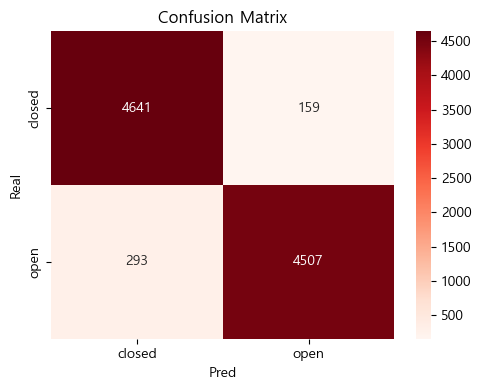

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_metrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(conf_metrix, annot=True, fmt="d", cmap='Reds',
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("../../results/images/best_model_bayesian_confusion_matrix.png")
plt.show()

In [ ]:
# best_hp 기반 모델
model=Sequential()
model.add(Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(96, 3, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.0010992362868788867),
            loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
# 학습
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, verbose=1,
                callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/20
2400/2400 [==============================] - 85s 35ms/step - loss: 0.6883 - accuracy: 0.8864 - val_loss: 0.2824 - val_accuracy: 0.8917
Epoch 2/20
2400/2400 [==============================] - 81s 34ms/step - loss: 0.1843 - accuracy: 0.9309 - val_loss: 0.2670 - val_accuracy: 0.8899
Epoch 3/20
2400/2400 [==============================] - 134s 56ms/step - loss: 0.1508 - accuracy: 0.9451 - val_loss: 0.4662 - val_accuracy: 0.8238
Epoch 4/20
2400/2400 [==============================] - 246s 102ms/step - loss: 0.1259 - accuracy: 0.9569 - val_loss: 0.4410 - val_accuracy: 0.8155
Epoch 5/20
2400/2400 [==============================] - 75s 31ms/step - loss: 0.1043 - accuracy: 0.9626 - val_loss: 0.4626 - val_accuracy: 0.7548
Epoch 6/20
2400/2400 [==============================] - 76s 32ms/step - loss: 0.1047 - accuracy: 0.9656 - val_loss: 0.3459 - val_accuracy: 0.9100
Epoch 7/20
2400/2400 [==============================] - 77s 32ms/step - loss: 0.0932 - accuracy: 0.9694 - val_loss: 0.118

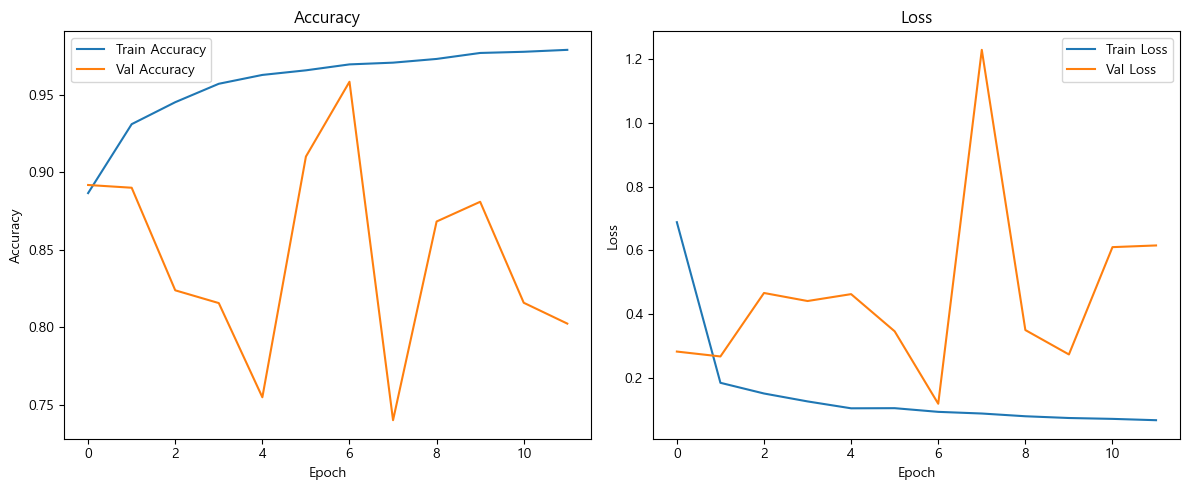

In [18]:
plt.figure(figsize=(12, 5))

# acc
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/best_model_bayesian_training_plot.png")
plt.show()

In [19]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps)
y_pred=(y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

601/601 [==============================] - 18s 29ms/step
              precision    recall  f1-score   support

      closed       0.94      0.98      0.96      4800
        open       0.98      0.94      0.96      4800

    accuracy                           0.96      9600
   macro avg       0.96      0.96      0.96      9600
weighted avg       0.96      0.96      0.96      9600



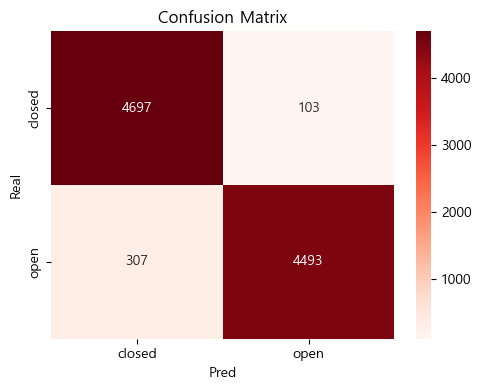

In [20]:
conf_metrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_metrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=["closed", "open"],
            yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.tight_layout()
#plt.savefig("../../results/images/final_model_confusion_matrix.png")
plt.show()

- 불안정하게 출렁이면서 overfitting 가능성을 보임  
- val accuracy가 출렁임 (오락가락)  
- val loss가 급등/급락 (폭발 -> 감소 반복)  
- 모델이 train 데이터에는 과하게 잘 맞고, val에는 일반화가 부족한 상황  